Use threads from forum, create Naive Bayes classifier to predict the type of mental disorder

In [1]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter
import nltk
from sklearn.metrics import f1_score
nltk.download('punkt')
import warnings
import jamspell
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
% matplotlib inline

/Users/sli/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sli/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to /Users/sli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import data
data_path = '/Users/sli/Projects/data/mental_health_forum_data/'
filename = data_path + 'label_and_description.csv'

df = pd.read_csv(filename,usecols=['label', 'dialog'] )

In [3]:
test_dialog = df.dialog[0]
test_dialog

'i feel like i m a faliure at the moment i ca nt work and i feel like i m expected to be there fighting on and pretending that i am fine and that my world is nt upside down at the moment  that i do nt have a MH prob and that i m just a normal 22 year old with lots of friends and a great social life  . when acually what i m doing is sitting at home every day either running around like a headless chickin thinking i m on top of the world and i can fly and planning how to kill myself whilst i have the energy to then feeling so low and having no energy and just wanting to stay in bed and hide away from the world just keep my head under the covers keep the curtains closed and to go to sleep and die as i have no energy to do it myself .. i ca nt even have a relationship without messing it up my friendships well there s on a few of those that are stable i do nt really have much of a soical life other then seeing a few people not like loads of friends going out drinking   i ca nt even cut my ar

In [4]:
# Preprocess paragraph
# Remove the extrac ., .., ! etc.
def preprocess(paragraph):
    return " ".join(re.split(r"\s+|[!,;:?.'-]\s*", paragraph))

In [5]:
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('model_en.bin')

False

In [8]:
# Create customized tokenize function
# -- Remove numbers
# -- Simplify long words
# -- Find the common stem
from nltk.tokenize import casual_tokenize
from nltk.stem.porter import PorterStemmer

def tokenize(text, if_cap=False):
    tokens = [word for word in casual_tokenize(preprocess(text), reduce_len=True, strip_handles=True)]
                
    stemmer = PorterStemmer()
    stems = [stemmer.stem(item) for item in tokens]
    
    return stems

In [9]:
# Create customized tokenize function
# -- Remove numbers
# -- Simplify long words
# -- Perform spell correction based on single word
# -- Find the common stem
def spell_tokenize(text):
    tokens = []
    for word in casual_tokenize(preprocess(text), reduce_len=True, strip_handles=True):
        if not (bool(re.search(r'\d', word) or len(word)>10)):
            corr_word = corrector.GetCandidates([word], 0)
            if (len(corr_word) >0) and (corr_word[0] != word):
                for candidate in corr_word[:1]:
                    tokens.append(candidate)
            else:
                tokens.append(word)
                
    stemmer = PorterStemmer()
    stems = [stemmer.stem(item) for item in tokens]
    
    return stems

In [10]:
cat_num = 7
max_rate = 1/cat_num
min_rate = 1/(100*cat_num)
cutoff_index = 10000
corpus_train = []
raw_label_train = []

In [11]:
# Compare the effect with/without spell correction
for i in range(cutoff_index):
    corpus_train.append(df.dialog[i])
    raw_label_train.append(df.label[i])

cvectorizer_tok = CountVectorizer(analyzer='word', tokenizer=tokenize, stop_words='english', binary=True)
count_data = cvectorizer_tok.fit_transform(corpus_train)
count_data = np.array(count_data.todense())
print(f"feature size without spell correct: {count_data.shape[1]}")

# cvectorizer_spel_tok = CountVectorizer(analyzer='word', tokenizer=spell_tokenize, stop_words='english', min_df=min_rate, max_df=max_rate, binary=True)
# count_spel_data = cvectorizer_spel_tok.fit_transform(corpus_train)
# count_spel_data = np.array(count_spel_data.todense())
# print(f"feature size with spell correct: {count_spel_data.shape[1]}")

feature size without spell correct: 29171


In [26]:
# feature_name = cvectorizer_tok.get_feature_names()
# tt_count = np.sum(count_data, axis=0)
# count_dict = dict(zip(feature_name, tt_count))

In [122]:
# Obtain train and test group
cutoff_index = int(len(df) * 0.8)

In [22]:
# Use CountVectorizer
corpus_train = []
raw_label_train = []
for i in range(cutoff_index):
    corpus_train.append(df.dialog[i])
    raw_label_train.append(df.label[i])
cvectorizer_tok = CountVectorizer(analyzer='word', tokenizer=tokenize, stop_words='english', min_df=min_rate, max_df=max_rate, binary=True)
cvectorizer_tok = cvectorizer_tok.fit(corpus_train)
train_count_data = cvectorizer_tok.transform(corpus_train)
train_count_data = np.array(train_count_data.todense())
print(f"size of training data: {train_count_data.shape}")

size of training data: (10000, 3551)


In [18]:
# Remove words from test documents that is not in training data
# Use a small portion of each text to take a test
corpus_test = []
raw_label_test = []
for i in range(len(df)-cutoff_index):
    corpus_test.append(df.dialog[cutoff_index+i])
    raw_label_test.append(df.label[cutoff_index+i])
test_count_data = cvectorizer_tok.transform(corpus_test)
test_count_data = np.array(test_count_data.todense())
print(f"size of testing data: {test_count_data.shape}")

In [24]:
# Use TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
tvectorizer_tok = TfidfTransformer(cvectorizer_tok)
train_tfidf_data = tvectorizer_tok.transform(train_count_data)
train_tfidf_data = np.array(train_tfidf_data.todense())

# Remove words from test documents that is not in training data
# Use a small portion of each text to take a test
corpus_test = []
raw_label_test = []
for i in range(len(df)-cutoff_index):
    corpus_test.append(df.dialog[cutoff_index+i])
    raw_label_test.append(df.label[cutoff_index+i])
test_tfidf_data = tvectorizer_tok.transform(corpus_test)
test_tfidf_data = np.array(test_tfidf_data.todense())
print(f"size of training data: {train_tfidf_data.shape}, size of testing data: {test_tfidf_data.shape}")

NotFittedError: idf vector is not fitted

In [25]:
len(raw_label_train)

10000

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
label_encoder = LabelEncoder()
encoded_label_train = label_encoder.fit_transform(raw_label_train)
# encoded_label_test = label_encoder.fit_transform(
# label_binary_train = label_binarize(y=encoded_label_train, classes=np.arange(7))
# label_binary_test = label_binarize(y=encoded_label_test, classes=np.arange(7))

In [16]:
label_encoder.

<bound method BaseEstimator.get_params of LabelEncoder()>

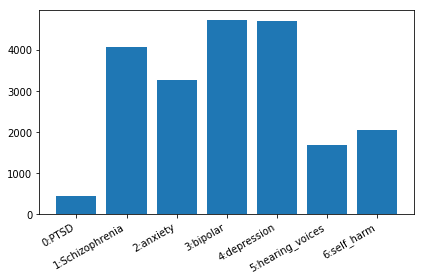

In [134]:
# Assess class balance issues
counter_label = Counter(encoded_label_train)
label_num = []
label_count = []
for i, j in zip(counter_label.keys(),counter_label.values()):
    label_num.append(i)
    label_count.append(j)

fig = plt.figure()
ordered_index = np.arange(7)
label_name_num = [str(num)+':'+name for name, num, in zip(lable_encoder.inverse_transform(ordered_index), ordered_index)]
label_counts = [count for _, count in sorted(zip(label_num, label_count))]
plt.bar(label_name_num,label_counts)
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

nb = OneVsRestClassifier(MultinomialNB())
nb = nb.fit(train_count_data, label_binary_train)
y_train_count_predict = nb.predict(train_count_data)
y_test_count_predict = nb.predict(test_count_data)

train_count_label = np.argmax(label_binary_train, axis=1)
train_count_predict = np.argmax(y_train_count_predict, axis=1)
f1_train = f1_score(train_count_label, train_count_predict, average='weighted')
print(f"Training f1 score: {round(f1_train, 2)}")

test_label = np.argmax(label_binary_test, axis=1)
predict_count_label = np.argmax(y_test_count_predict, axis=1)
f1_test = f1_score(test_label, predict_count_label, average='weighted')
print(f"Testing f1 score: {round(f1_test, 2)}")

In [126]:
from sklearn import svm

svm = svm.LinearSVC()
svm = svm.fit(train_count_data, encoded_label_train)
y_train_count_predict = svm.predict(train_count_data)
y_test_count_predict = svm.predict(test_count_data)

train_count_label = np.argmax(label_binary_train, axis=1)
train_count_predict = y_train_count_predict
f1_train = f1_score(train_count_label, train_count_predict, average='weighted')
print(f"Training f1 score: {round(f1_train, 2)}")

test_count_label = np.argmax(label_binary_test, axis=1)
predict_count_label = y_test_count_predict
f1_test = f1_score(test_count_label, predict_count_label, average='weighted')
print(f"Testing f1 score: {round(f1_test, 2)}")

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = OneVsRestClassifier(LinearDiscriminantAnalysis())
lda = lda.fit(train_tfidf_data, label_binary_train)
y_train_tfidf_predict = lda.predict(train_tfidf_data)
y_test_tfidf_predict = lda.predict(test_tfidf_data)

train_tfidf_label = np.argmax(label_binary_train, axis=1)
train_tfidf_predict = np.argmax(y_train_tfidf_predict, axis=1)
f1_train = f1_score(train_tfidf_label, train_tfidf_predict, average='weighted')
print(f"Training f1 score: {round(f1_train, 2)}")

test_tfidf_label = np.argmax(label_binary_test, axis=1)
predict_tfidf_label = np.argmax(y_test_tfidf_predict, axis=1)
f1_test = f1_score(test_tfidf_label, predict_tfidf_label, average='weighted')
print(f"Testing f1 score: {round(f1_test, 2)}")

Training f1 score: 0.72
Testing f1 score: 0.56


In [130]:
encoded_label_train.shape

(10000,)

In [138]:
from sklearn import svm

svm = svm.LinearSVC()
svm = svm.fit(train_tfidf_data, encoded_label_train)
y_train_tfidf_predict = svm.predict(train_tfidf_data)
y_test_tfidf_predict = svm.predict(test_tfidf_data)

train_tfidf_label = np.argmax(label_binary_train, axis=1)
train_tfidf_predict = y_train_tfidf_predict
f1_train = f1_score(train_tfidf_label, train_tfidf_predict, average=None)
print(f"Training f1 score: {round(np.mean(f1_train), 2)}")

test_tfidf_label = np.argmax(label_binary_test, axis=1)
predict_tfidf_label = y_test_tfidf_predict
f1_test = f1_score(test_tfidf_label, predict_tfidf_label, average=None)
print(f"Testing f1 score: {round(np.mean(f1_test), 2)}")

Training f1 score: 0.83
Testing f1 score: 0.61


In [139]:
f1_train

array([0.85578069, 0.85193452, 0.78308365, 0.80948384, 0.76090101,
       0.85817743, 0.86417273])

In [140]:
f1_test

array([0.56481481, 0.65690377, 0.53133159, 0.64262295, 0.55577769,
       0.6340882 , 0.71850394])

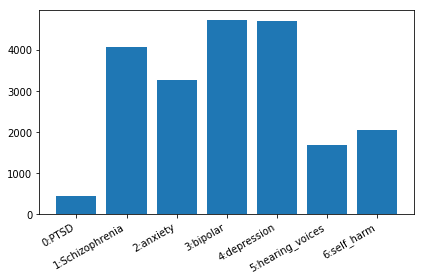

In [146]:
# Assess class balance issues
counter_label = Counter(encoded_label_train)
label_num = []
label_count = []
for i, j in zip(counter_label.keys(),counter_label.values()):
    label_num.append(i)
    label_count.append(j)

fig = plt.figure()
ordered_index = np.arange(7)
label_name_num = [str(num)+':'+name for name, num, in zip(lable_encoder.inverse_transform(ordered_index), ordered_index)]
label_counts = [count for _, count in sorted(zip(label_num, label_count))]
plt.bar(label_name_num,label_counts)
fig.autofmt_xdate()
plt.tight_layout()

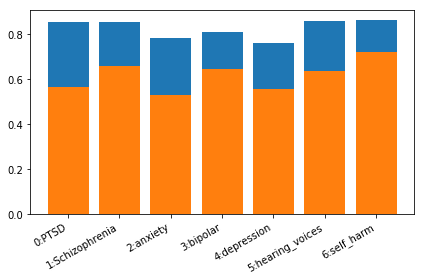

In [145]:
fig = plt.figure()
plt.bar(label_name_num, f1_train)
plt.bar(label_name_num, f1_test)
fig.autofmt_xdate()
plt.tight_layout()

In [181]:
feature_names = tvectorizer_tok.get_feature_names()
disorder_dict = dict()
for i in range(svm.coef_.shape[0]):
    coef = np.round(np.abs(svm.coef_[i,:]), 2)
    feature_idx = coef.argsort()[-10:][::-1]
    key_feature = [{feature_names[i]: coef[i]} for i in feature_idx]
    disorder_dict[label_name_num[i].split(':')[-1]] = key_feature

In [184]:
pd.DataFrame(disorder_dict)

,PTSD,Schizophrenia,anxiety,bipolar,depression,hearing_voices,self_harm
0,{'ptsd': 5.1},{'schizophrenia': 8.24},{'schizophrenia': 4.06},{'bipolar': 7.43},{'schizophrenia': 5.7},{'voic': 6.07},{'sh': 5.5}
1,{'flashback': 3.38},{'schizophren': 4.11},{'bipolar': 3.69},{'schizophrenia': 6.21},{'bipolar': 4.17},{'schizophrenia': 3.43},{'harm': 4.5}
2,{'trauma': 2.74},{'bipolar': 3.5},{'voic': 3.22},{'manic': 4.21},{'voic': 3.43},{'intervoic': 2.83},{'scar': 3.61}
3,{'traumat': 2.34},{'delus': 3.17},{'anxiou': 3.19},{'stan': 3.99},{'schizophren': 3.21},{'hear': 2.38},{'harmer': 3.01}
4,{'rape': 2.31},{'risperd': 2.51},{'sh': 2.72},{'voic': 3.13},{'ptsd': 2.64},{'dialogu': 2.14},{'si': 2.87}
5,{'emdr': 2.13},{'manic': 2.41},{'gad': 2.7},{'schizophren': 2.97},{'stabilis': 2.35},{'hearer': 2.03},{'urg': 2.73}
6,{'schizophrenia': 1.94},{'psychosi': 2.34},{'panic': 2.7},{'polar': 2.85},{'grandfath': 2.32},{'bipolar': 1.94},{'shing': 2.6}
7,{'voic': 1.76},{'overlap': 2.33},{'delus': 2.23},{'cyclothymia': 2.84},{'sh': 2.27},{'shake': 1.92},{'implement': 2.57}
8,{'dissoci': 1.74},{'depot': 2.31},{'xanax': 2.23},{'hh': 2.84},{'stan': 2.16},{'manner': 1.7},{'schizophrenia': 2.3}
9,{'ocd': 1.6},{'schizoaffect': 2.18},{'psychosi': 2.19},{'bp': 2.8},{'hypoman': 2.14},{'louder': 1.69},{'h': 2.18}


In [ ]:
# Analyze each sentence and put negative word on top

In [ ]:
# Try LSA and LDiA with LDA

In [ ]:
# # Data cleaning
# from nltk.tokenize import RegexpTokenizer
# from collections import Counter

# rg_token = RegexpTokenizer(r'\w+[]\\|$[0-9.]+|\S+')

In [ ]:
# from nltk.tokenize import TreebankWordTokenizer

# test_

# tree_token = TreebankWordTokenizer()
# Counter(tree_token.tokenize(df.dialog[0])).most_common()